In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.stats import norm
from scipy.stats import mode

## Define the likelihood and other stuff
From Pat's example notebook

In [18]:
def loglike(params):
    our_model = CubicSpline(x_spline_points, params)
    # this evaluates the equation ln(p(x) | parameters) = ... a few cells above.
    return np.sum(norm.logpdf(realistic_data - our_model(xvals), scale=measurement_noise_standard_deviation))

# scipy prefers to minimize things instead of maximize things
def neg_ll(params):
    return -loglike(params)
import scipy.optimize as so

In [8]:
from transdimensional_spline_fitting import BaseSplineModel
class SmoothCurveDataObj(object):
    """
    A data class that can be used with our spline model
    """
    def __init__(self, data_xvals, data_yvals, data_errors):
        self.data_xvals = data_xvals
        self.data_yvals = data_yvals
        self.data_errors = data_errors

class FitSmoothCurveModel(BaseSplineModel):
    """
    Example of subclassing `BaseSplineModel` to create a likelihood
    that can then be used for sampling.

    Assumes use with `ArbitraryCurveDataObj`

    You also need to create a simple data class to go along with this. This
    allows the sampler to be used with arbitrary forms of data...
    """
    def ln_likelihood(self, config, heights):
        """
        Simple Gaussian log likelihood where the data are just simply
        points in 2D space that we're trying to fit.

        This could be something more complicated, though, of course. For example,
        You might create your model from the splines (`model`, below) and then use that
        in some other calculation to put it into the space for the data you have.

        :param data_obj: `ArbtraryCurveDataObj` -- an instance of the data object class associated with this likelihood.
        :return: log likelihood
        """
        # be careful of `evaluate_interp_model` function! it does require you to give a list of xvalues,
        # which don't exist in the base class!
        model = self.evaluate_interp_model(self.data.data_xvals, heights, config)
        return np.sum(norm.logpdf(model - self.data.data_yvals, scale=self.data.data_errors))

## Other function definitions

In [28]:
def get_median_CIs(xvals, model, results, lower=5, upper=95, burnin=0, Niter=None):
    '''
    Return median and CIs of spline posteriors.
    '''

    if lower<1 and upper<1:
        print("warning! Make sure upper and lower CI bounds are between 0-100 (not 0-1)!")

    if not Niter:
        Niter = len(results.heights)
    
    # Make array of all chain draws
    xyz = np.array([model.evaluate_interp_model(xvals, results.heights[_], results.configurations[_].astype(bool)) for _ in range(burnin,Niter)])
    
    median = [np.median(xyz[:,_]) for _ in range(len(xvals))]
    ci_lower = [np.percentile(xyz[:,_], lower) for _ in range(len(xvals))]
    ci_upper = [np.percentile(xyz[:,_], upper) for _ in range(len(xvals))]

    return(median,(ci_lower,ci_upper))

In [58]:
def plot_draws(xvals, model, results, data, true_signal, err, burnin):
    for ii in range(1000):
        idx = np.random.choice(np.arange(50_000))
        new_xvals = np.linspace(0, 1, num=100)
        plt.plot(xvals, model.evaluate_interp_model(new_xvals, results.heights[idx+burnin], results.configurations[idx+burnin].astype(bool)), alpha=0.01, c='k')
    plt.errorbar(xvals, data, yerr=err, c='C0', fmt='o', alpha=1, label='Data', zorder=1000)
    plt.plot(xvals, true_signal, c='r', ls='--', label='True signal', zorder=1001)
    plt.show()

    return 0


In [55]:
def plot_CIs(xvals, median, data, true_signal, CIs, err):
    plt.plot(xvals, median, label='posterior median', color='k')
    plt.fill_between(xvals, CIs[0], CIs[1], alpha=0.3,label='90% Credible Interval', color='k')
    plt.plot(xvals, true_signal, c='r', ls='--', label='True signal', zorder=1001)
    plt.errorbar(xvals, data, yerr=err, c='C0', fmt='o', alpha=1, label='Data', zorder=1000)
    plt.legend(loc='best')

    return 0

# Generate Fake Data
Taken from Pat's example notebook

In [70]:
# random sinusoids of different frequencies

Nfreqs = 3
maxfreq = 3

# list of frequencies
frequencies = np.linspace(0, maxfreq, num=Nfreqs)
# list of random phases between 0 and 2pi. Use
# random values drawn from [0,1] multiplied by 2pi
phases = np.random.rand(Nfreqs) * 2 * np.pi
amplitudes = np.random.rand(Nfreqs)

# make coefficients random, but then put them on roughly
# the same scale by dividing by dx^degres
def sinusoid(times, freq, phase, amplitude):
    return amplitude * np.sin(2 * np.pi * freq * times + phase)



def sum_of_sinusoids(xvals, freqs, phases, amplitudes):
    """evaluate a polynomial of degree (len(params) - 1) at xvalues     

    Args:
        xvals (numpy.ndarray): list of x-axis points at which to evaluate polynomail
        params (numpy.ndarray): list of polynomial coefficients (constant -> max degree)
    """
    # value of our curve
    yvals = np.zeros_like(xvals)
    
    for amp, freq, phase in zip(amplitudes, freqs, phases):
        yvals += sinusoid(xvals, freq, phase, amp)
        # print(coeff*xvals[-1]**ii)
    return yvals

In [71]:
xvals = np.linspace(0, 1, num=100)

measurement_noise_standard_deviation = 0.8

# measurement noise at each point, using random number generator
measurement_noise = measurement_noise_standard_deviation * np.random.randn(xvals.size) 
true_signal = sum_of_sinusoids(xvals, frequencies, phases, amplitudes)
realistic_data = true_signal + measurement_noise

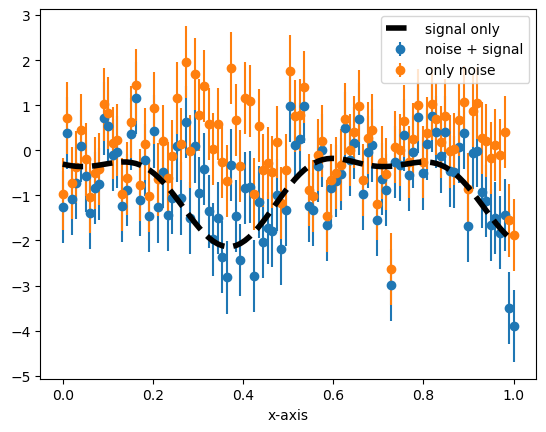

In [72]:
plt.errorbar(xvals, realistic_data, label='noise + signal', yerr=measurement_noise_standard_deviation, fmt='o', zorder=-1)
plt.errorbar(xvals, measurement_noise, label='only noise', yerr=measurement_noise_standard_deviation, fmt='o', zorder=-1)
plt.plot(xvals, true_signal, label='signal only', c='k', ls='--', lw=4)
plt.legend()
plt.xlabel('x-axis')
plt.show()

# Do actual RJMCMC

In [73]:
maxKnots=20
priorlims = [-4,4] # prior bounds on heights
Niter=100000
burnin=20000

In [74]:
data = SmoothCurveDataObj(xvals, realistic_data, measurement_noise_standard_deviation*np.ones(xvals.size))
curve_model = FitSmoothCurveModel(data, maxKnots, (xvals[0], xvals[-1]), (priorlims[0], priorlims[1]), interp_type='cubic')

# MCMC it
results = curve_model.sample(Niter, prior_test=False, proposal_weights=[1, 1, 1, 1])

100%|██████████| 100000/100000 [00:43<00:00, 2286.58it/s]


Map D = 7


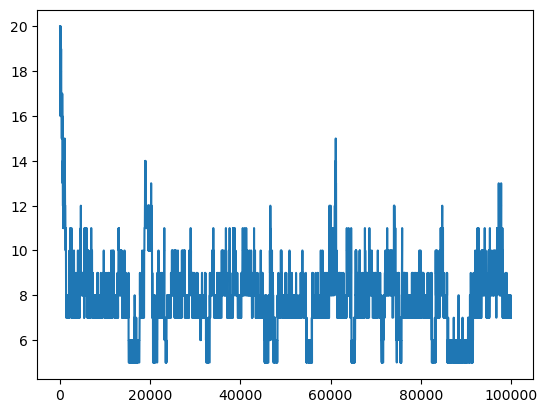

In [75]:
# Plot how dimension changes over iteration
Nvals = np.sum(results.configurations, axis=1)
plt.plot(Nvals)

mapD = int(mode(Nvals,axis=0,keepdims=True)[0][0])

print('Map D =', mapD)

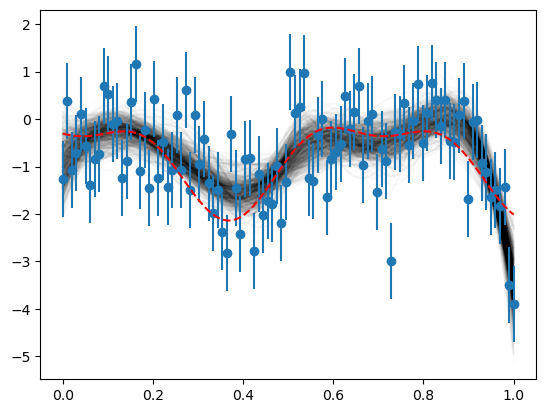

In [76]:
# Plot a few draws from the chain, along with data and true signal

for ii in range(1000):
    idx = np.random.choice(np.arange(50_000))
    new_xvals = np.linspace(0, 1, num=100)
    plt.plot(xvals, curve_model.evaluate_interp_model(new_xvals, results.heights[idx+burnin], results.configurations[idx+burnin].astype(bool)), alpha=0.01, c='k')
plt.errorbar(xvals, realistic_data, yerr=measurement_noise_standard_deviation, c='C0', fmt='o', alpha=1, label='Data', zorder=1000)
plt.plot(xvals, true_signal, c='r', ls='--', label='True signal', zorder=1001)
plt.show()

In [77]:
# Get median and CIs
median, CIs = get_median_CIs(new_xvals, curve_model, results, burnin=20_000, Niter=100_000)

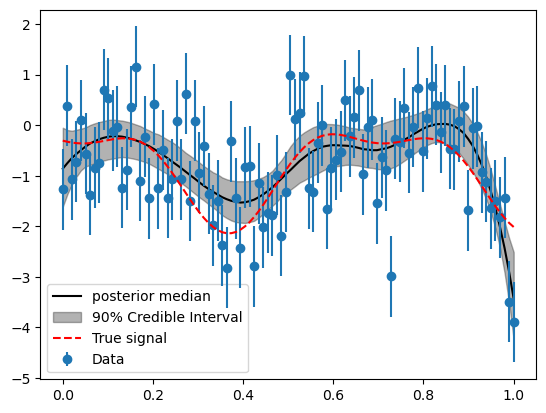

In [78]:
# Plot
plt.plot(new_xvals, median, label='posterior median', color='k')
plt.fill_between(new_xvals, CIs[0], CIs[1], alpha=0.3,label='90% Credible Interval', color='k')
plt.plot(xvals, true_signal, c='r', ls='--', label='True signal', zorder=1001)
plt.errorbar(xvals, realistic_data, yerr=measurement_noise_standard_deviation, c='C0', fmt='o', alpha=1, label='Data', zorder=1000)
plt.legend(loc='best')

# Fixed D: map D from previous run

In [79]:
fixD = mapD

data = SmoothCurveDataObj(xvals, realistic_data, measurement_noise_standard_deviation*np.ones(xvals.size))
curve_model = FitSmoothCurveModel(data, fixD, (xvals[0], xvals[-1]), (priorlims[0], priorlims[1]), interp_type='cubic')

In [80]:
# MCMC it
#  setting first two weights to zero turns off birth and death moves, making it a fixD run
results = curve_model.sample(Niter, prior_test=False, proposal_weights=[0, 0, 1, 1])

100%|██████████| 100000/100000 [00:46<00:00, 2156.06it/s]


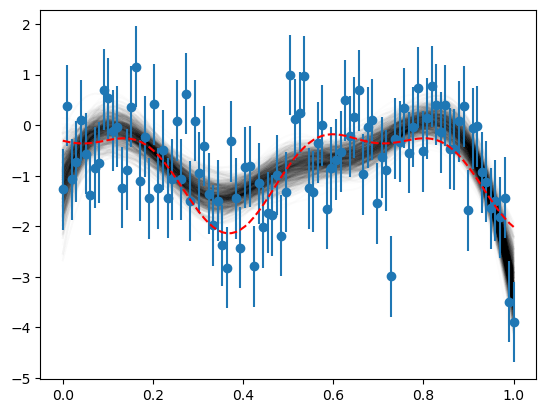

0

In [81]:
plot_draws(xvals, curve_model, results, realistic_data, true_signal, measurement_noise_standard_deviation, burnin)

In [82]:
# Get median and CIs
median, CIs = get_median_CIs(new_xvals, curve_model, results, burnin=20_000, Niter=100_000)

0

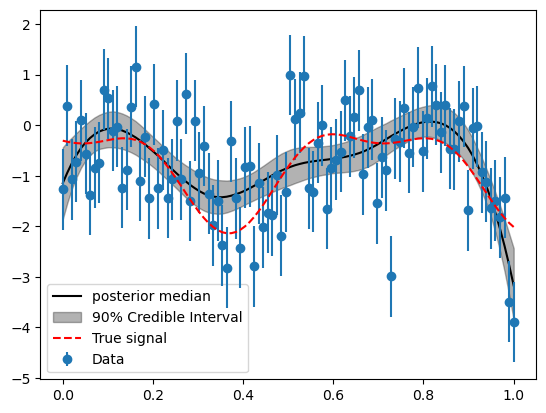

In [83]:
plot_CIs(xvals, median, realistic_data, true_signal, CIs, measurement_noise_standard_deviation)

# Use too few spline points

In [84]:
fixD = 4

data = SmoothCurveDataObj(xvals, realistic_data, measurement_noise_standard_deviation*np.ones(xvals.size))
curve_model = FitSmoothCurveModel(data, fixD, (xvals[0], xvals[-1]), (priorlims[0], priorlims[1]), interp_type='cubic')

In [85]:
# MCMC it
#  setting first two weights to zero turns off birth and death moves, making it a fixD run
results = curve_model.sample(Niter, prior_test=False, proposal_weights=[0, 0, 1, 1])

100%|██████████| 100000/100000 [00:44<00:00, 2264.54it/s]


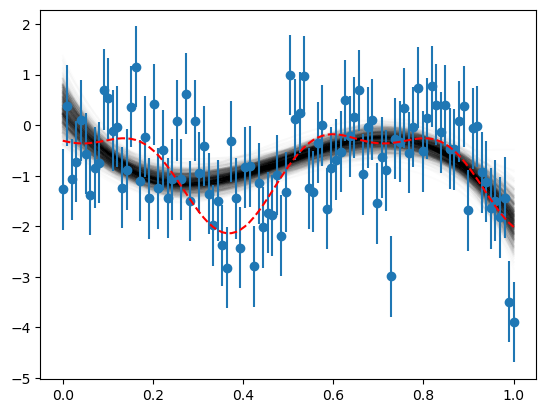

0

In [86]:
plot_draws(xvals, curve_model, results, realistic_data, true_signal, measurement_noise_standard_deviation, burnin)

In [87]:
# Get median and CIs
median, CIs = get_median_CIs(new_xvals, curve_model, results, burnin=20_000, Niter=100_000)

0

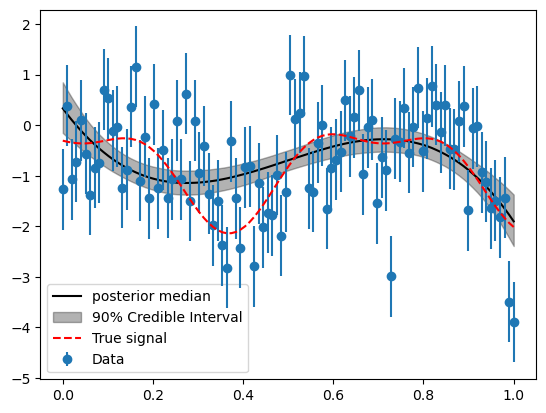

In [88]:
plot_CIs(xvals, median, realistic_data, true_signal, CIs, measurement_noise_standard_deviation)

# Use too many spline points

In [89]:
fixD = 20

data = SmoothCurveDataObj(xvals, realistic_data, measurement_noise_standard_deviation*np.ones(xvals.size))
curve_model = FitSmoothCurveModel(data, fixD, (xvals[0], xvals[-1]), (priorlims[0], priorlims[1]), interp_type='cubic')

In [90]:
# MCMC it
#  setting first two weights to zero turns off birth and death moves, making it a fixD run
results = curve_model.sample(Niter, prior_test=False, proposal_weights=[0, 0, 1, 1])

100%|██████████| 100000/100000 [00:45<00:00, 2177.25it/s]


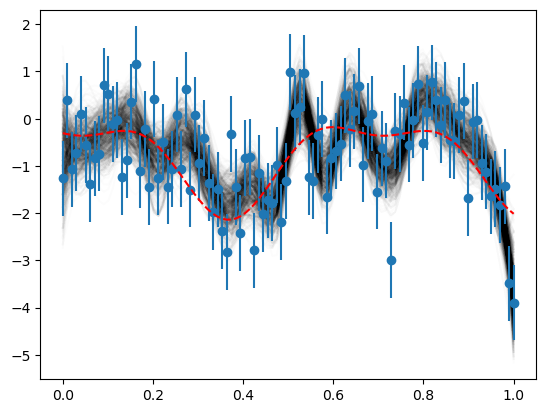

0

In [91]:
plot_draws(xvals, curve_model, results, realistic_data, true_signal, measurement_noise_standard_deviation, burnin)

In [92]:
# Get median and CIs
median, CIs = get_median_CIs(new_xvals, curve_model, results, burnin=20_000, Niter=100_000)

0

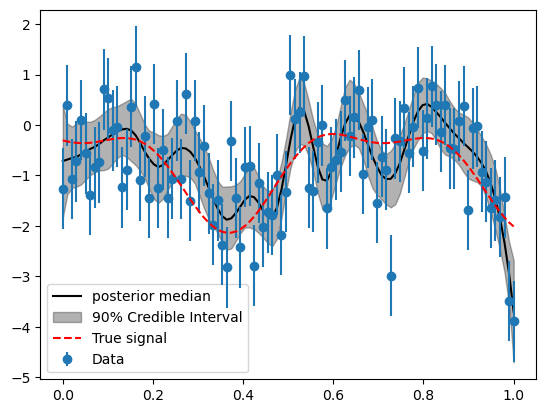

In [93]:
plot_CIs(xvals, median, realistic_data, true_signal, CIs, measurement_noise_standard_deviation)